# Convolutional Neural Network 구현
- MNIST 손글씨 data를 이용하여 CNN을 학습하고 MLP와 결과와 비교.

In [54]:
import matplotlib.pyplot as plt
# 학습결과 그래프 함수
# loss 그래프
def plot_loss(history):
#     plt.figure(figsize=(10,7))
    plt.plot(history.history['loss'], label='Train loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

In [55]:
# accuracy 그래프
def plot_accuracy(history):
#     plt.figure(figsize=(10,7))
    plt.plot(history.history['accuracy'], label='Train accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    plt.title('Accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()

# MNIST CNN 적용

In [56]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Input
import numpy as np

In [57]:
np.random.seed(1)
tf.random.set_seed(1)

In [58]:
# 하이퍼파라미터 설정
LEARNING_RATE = 0.001
N_EPOCHS = 20
N_BATCHS = 100
N_CLASS = 10

In [59]:
# 데이터셋 로드
(train_image, train_label), (test_image, test_label) = keras.datasets.mnist.load_data()
train_image.shape, train_label.shape, test_image.shape, test_label.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [60]:
 # 추가 변수 설정
 N_TRAIN = train_image.shape[0]
 N_TEST = test_image.shape[0]

In [61]:
# 전처리 : 이미지 - 정규화(0 ~ 1)
#          label - one hot encoding (생략-loss:sparse_categroica_crossentropy)
X_train, X_test = train_image/255. , test_image/255.
X_train = X_train[..., np.newaxis]  #channel 축을 늘리는 작업. (28,28)=>(28,28,1)
X_test = X_test[..., np.newaxis]
y_train, y_test = train_label, test_label

In [62]:
X_train.shape

(60000, 28, 28, 1)

In [63]:
# dataset 구성
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(N_TRAIN).batch(N_BATCHS, drop_remainder=True).repeat()
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(N_BATCHS)

# CNN 모델 구성
- convolution layer의 filter 개수는 적은 개수에서 점점 늘려간다.
- input shape(입력 이미지의 size) : 3차원 (height, width, channel)
    - 흑백 : (height, width, 1)
    - 컬러 : (height, width, 3)

In [64]:
def create_model():
    model = keras.Sequential()
    model.add(layers.Input((28, 28, 1))) # Input shape
    # Convolution layer: Conv2D -> MaxPool2D
    model.add(layers.Conv2D(filters=32, #Filter 개수
                            kernel_size=(3,3), #Filter(Kernel)의 height,width. h/w가 같은 경우에는 정수
                            padding='same', #Padding 방식: 'valid', 'same' - 대소문자는 상관없다.
                            strides=(1,1), # Stride설정: (상하, 좌우). 상하/좌우 같은 값이면 정수
                            activation='relu'))
    # Max Pooling layer => MaxPool2D
    model.add(layers.MaxPool2D(pool_size=(2,2), #영역 height,width 크기 지정. h/w 같으면 정수. default=(2,2) = 2: Feature map size를 절반으로 줄인다.
                               strides=(2,2), # default: None => pool_size를 사용. 두개값이 같으면 정수
                               padding='same')) # "valid" - 뒤에 남는 것은 버린다.

    model.add(layers.Conv2D(filters=64, 
                            kernel_size=3, 
                            padding='same',
                            strides=1,
                            activation='relu'))
    model.add(layers.MaxPool2D(padding='same'))# pool_size, strides: default 값으로 설정.

    # Classification Layer -> Fully Connected Layer
    # Conv 거친 Feature map은 3차원 배열 => Flatten():1차원 배열로 변환
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    # 출력
    model.add(layers.Dense(N_CLASS, activation='softmax'))

    return model

In [65]:
model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               803072    
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

In [66]:
# 3*3*1*32+32
3*3*32*64+64

18496

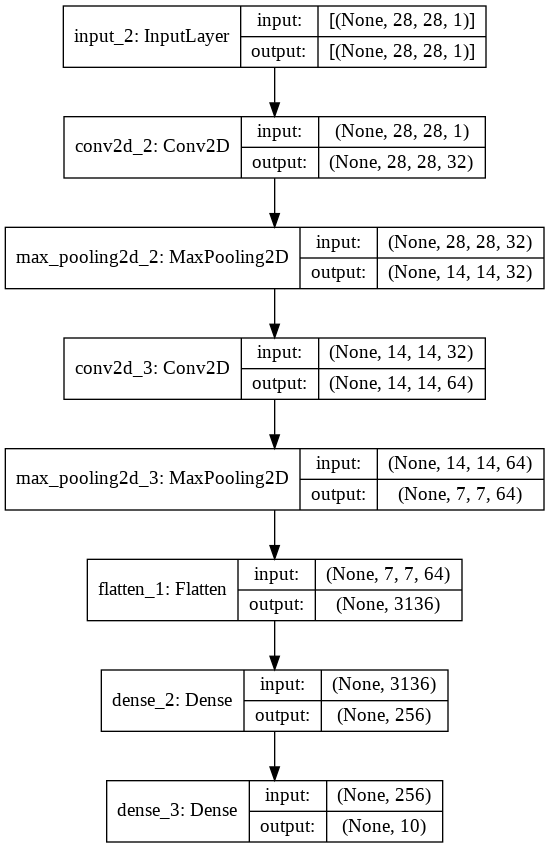

In [67]:
keras.utils.plot_model(model, show_shapes=True)

In [68]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
              loss='sparse_categorical_crossentropy',   #sparse_categorical_crossentropy: y가 one hot encoding 이 안된 경우 사용.
              metrics=['accuracy'])

In [69]:
y_train.shape

(60000,)

In [70]:
steps_per_epoch = N_TRAIN // N_BATCHS
validation_steps = int(np.ceil(N_TEST / N_BATCHS))

history = model.fit(train_dataset, 
                    epochs=N_EPOCHS, 
                    steps_per_epoch=steps_per_epoch,
                    validation_data=test_dataset,
                    validation_steps=validation_steps)

Epoch 1/20
600/600 [==============================] - 4s 5ms/step - loss: 0.3779 - accuracy: 0.8824 - val_loss: 0.0424 - val_accuracy: 0.9862
Epoch 2/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0456 - accuracy: 0.9867 - val_loss: 0.0357 - val_accuracy: 0.9889
Epoch 3/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0278 - accuracy: 0.9916 - val_loss: 0.0273 - val_accuracy: 0.9903
Epoch 4/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0221 - accuracy: 0.9928 - val_loss: 0.0344 - val_accuracy: 0.9889
Epoch 5/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0172 - accuracy: 0.9944 - val_loss: 0.0267 - val_accuracy: 0.9904
Epoch 6/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0131 - accuracy: 0.9956 - val_loss: 0.0321 - val_accuracy: 0.9896
Epoch 7/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0084 - accuracy: 0.9973 - val_loss: 0.0306 - val_accuracy: 0.9914
Epoch 

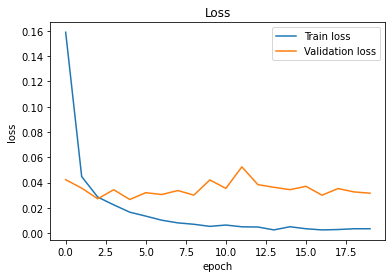

In [71]:
plot_loss(history)

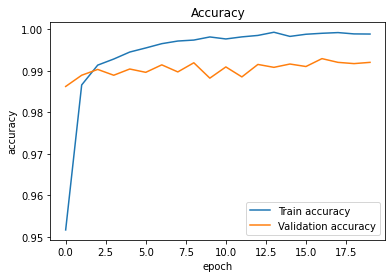

In [72]:
plot_accuracy(history)

In [73]:
model.evaluate(test_dataset)

100/100 [==============================] - 0s 3ms/step - loss: 0.0317 - accuracy: 0.9920


[0.031685277819633484, 0.9919999837875366]

In [74]:
# 새로운 데이터 추론
pred = model.predict(X_test[:10])
pred_class = np.argmax(pred, axis=-1)

In [75]:
pred_class, y_test[:10]

(array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9]),
 array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9], dtype=uint8))

### prediction error가 발생한 example 확인

In [89]:
pred = model.predict(X_test)
pred_class = np.argmax(pred, axis=-1)
pred_class[:10]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])

In [97]:
# pred_class: 예측결과, y_test: 실제정답
# 예측이 틀린 index를 조회
error_idx = np.where(pred_class!=y_test)[0]
error_idx.size, error_idx

(80, array([  92,  340,  359,  619,  684,  883,  947,  965, 1014, 1039, 1112,
        1182, 1226, 1232, 1242, 1247, 1260, 1393, 1414, 1559, 1621, 1678,
        1709, 1790, 1901, 2070, 2118, 2129, 2130, 2135, 2293, 2369, 2597,
        2654, 2896, 2921, 2927, 2939, 2953, 3422, 3520, 3534, 3681, 3727,
        3767, 3808, 3850, 3853, 4176, 4199, 4201, 4265, 4369, 4443, 4536,
        4740, 4761, 4807, 4823, 4860, 5654, 5937, 5997, 6091, 6560, 6597,
        6625, 6755, 6847, 7928, 8094, 9009, 9015, 9642, 9664, 9692, 9698,
        9729, 9888, 9940]))

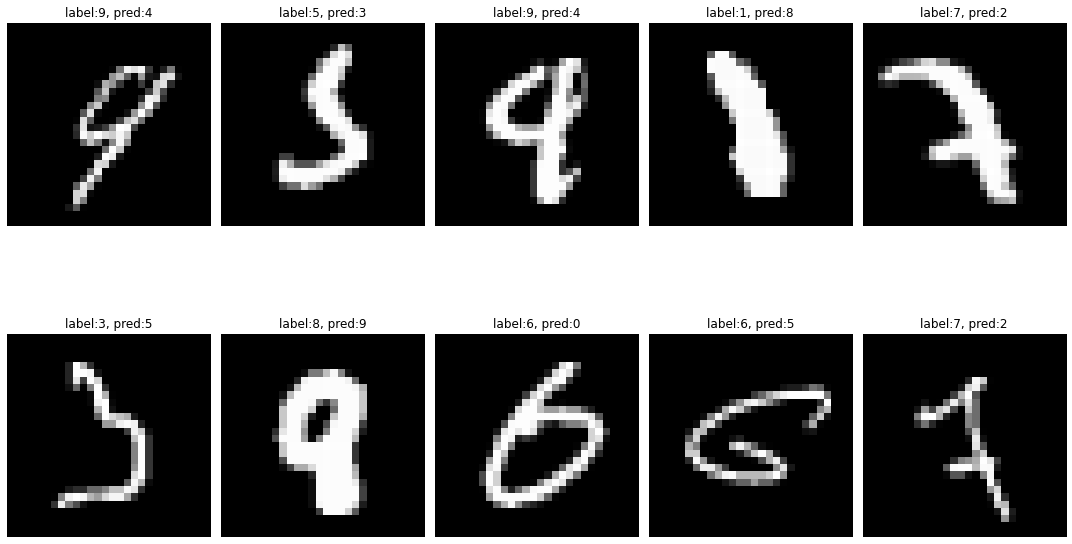

In [101]:
# 틀린것 10개 확인
plt.figure(figsize=(15,10))
for i in range(10):
    err = error_idx[i]
    plt.subplot(2,5,i+1)
    plt.imshow(test_image[err], cmap='gray')
    plt.title(f'label:{y_test[err]}, pred:{pred_class[err]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

# 모델 저장
1. 학습이 끝난 모델의 파라미터만 저장
1. 모델 전체 저장
1. Callback 함수를 이용해 학습시 가장 좋은 지표의 모델 저장

## 텐서플로 파일 타입
- checkpoint 
    - 모델의 weight를 저장하기 위한 파일타입
- SavedModel 
    - 모델의 구조와 파라미터들을 모두 저장하는 형식

## 학습한 Weight (파라미터) 저장 및 불러오기
- 가중치를 저장하여 나중에 재학습 없이 학습된 가중치를 사용할 수 있다.
- 저장: `model.save_weights("저장경로")`
- 불러오기: `model.load_weights('불러올경로')`
- 저장형식
    - Tensorflow Checkpoint (기본방식)
    - HDF5
        - `save_weights(.., save_format='h5')`

In [102]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [104]:
# 저장할 경로 생성
import os
base_dir = "/content/drive/MyDrive/saved_models" #모델/파라미터들을 저장할 root
weight_dir = os.path.join(base_dir, 'mnist', 'weights')
print(weight_dir)
if not os.path.isdir(weight_dir): 
    os.makedirs(weight_dir, exist_ok=True)
    #exist_ok=False(기본): 이미 경로가 있으면 예외발생, True: 예외발생 안시킴.
weight_path = os.path.join(weight_dir, 'mnist_cnn_weights.ckpt') # 저장할디렉토리 + 파일명

/content/drive/MyDrive/saved_models/mnist/weights


In [105]:
model.save_weights(weight_path)

In [106]:
new_model1 = create_model()
new_model1.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
              loss='sparse_categorical_crossentropy',   #sparse_categorical_crossentropy: y가 one hot encoding 이 안된 경우 사용.
              metrics=['accuracy'])

In [107]:
new_model1.evaluate(test_dataset)

100/100 [==============================] - 1s 3ms/step - loss: 2.3126 - accuracy: 0.1780


[2.313303232192993, 0.17180000245571136]

In [108]:
# 파일로 저장된 weight들을 생성된 모델(네트워크)에 저장
new_model1.load_weights(weight_path)

In [109]:
new_model1.evaluate(test_dataset)

100/100 [==============================] - 0s 3ms/step - loss: 0.0317 - accuracy: 0.9920


[0.031685277819633484, 0.9919999837875366]

In [ ]:
# new_model1.fit() # 이어서 학습

In [110]:
# hdf5형식으로 저장/불러오기
weight_h5_dir = os.path.join(base_dir, 'mnist', 'weight_h5')
if not os.path.isdir(weight_h5_dir):
    os.makedirs(weight_h5_dir)

weight_h5_path = os.path.join(weight_h5_dir, 'mnist_cnn_weight.h5')    
print(type(weight_h5_path), weight_h5_path)

<class 'str'> /content/drive/MyDrive/saved_models/mnist/weight_h5/mnist_cnn_weight.h5


In [111]:
model.save_weights(weight_h5_path, save_format='h5')

In [112]:
new_model2 = create_model()
new_model2.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
              loss='sparse_categorical_crossentropy',   #sparse_categorical_crossentropy: y가 one hot encoding 이 안된 경우 사용.
              metrics=['accuracy'])


In [113]:
new_model2.evaluate(test_dataset)

100/100 [==============================] - 1s 3ms/step - loss: 2.3159 - accuracy: 0.0876


[2.315847158432007, 0.08489999920129776]

In [114]:
new_model2.load_weights(weight_h5_path)
new_model2.evaluate(test_dataset)

100/100 [==============================] - 0s 3ms/step - loss: 0.0317 - accuracy: 0.9920


[0.031685277819633484, 0.9919999837875366]

## 전체 모델 저장하고 불러오기
- 저장: `model.save('저장할디렉토리')`
- 불러오기: `tf.keras.models.load_model('저장파일경로')`
- 저장 형식
    - Tensorflow SavedModel 형식(기본방식)
        - 모델 아키텍처 및 훈련 구성(옵티마이저, 손실 및 메트릭 포함)은 saved_model.pb 에 저장된다.
        - 파라미터는 variables/ 디렉토리에 저장된다.
        - https://www.tensorflow.org/guide/saved_model?hl=ko#the_savedmodel_format_on_disk
    - HDF5 형식
        - `save(..., save_format='h5')` 로 지정한다.
    

In [115]:
model_dir = os.path.join(base_dir, 'mnist', 'models', 'saved_model')
if not os.path.isdir(model_dir):
    os.makedirs(model_dir, exist_ok=True)
print(model_dir)

/content/drive/MyDrive/saved_models/mnist/models/saved_model


In [116]:
model.save(model_dir) #SavedModel 형식으로 저장시 디렉토리를 지정.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/saved_models/mnist/models/saved_model/assets


In [117]:
new_model3 = keras.models.load_model(model_dir)

In [118]:
new_model3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               803072    
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

In [119]:
new_model3.evaluate(test_dataset)

100/100 [==============================] - 0s 3ms/step - loss: 0.0317 - accuracy: 0.9920


[0.031685277819633484, 0.9919999837875366]

In [122]:
# h5형식으로 저장/불러오기
model_h5_dir = os.path.join(base_dir, 'mnist', 'models', 'h5_model')
if os.path.isdir(model_h5_dir):
    os.makedirs(model_h5_dir, exist_ok=True)
#h5 형식으로 저장할때 파일명까지 지정.
model_h5_path = os.path.join(model_h5_dir, 'mnist_cnn_model.h5')

In [123]:
model.save(model_h5_path, save_format='h5')

In [124]:
new_model4 = keras.models.load_model(model_h5_path)

In [125]:
new_model4.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               803072    
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

In [126]:
new_model4.evaluate(test_dataset)

100/100 [==============================] - 0s 3ms/step - loss: 0.0317 - accuracy: 0.9920


[0.031685277819633484, 0.9919999837875366]

## Callback을 사용한 모델 저장 및 Early Stopping
- callback은 학습하는 도중 특정 이벤트 발생시 호출되는 다양한 함수를 제공하여 자동화 처리를 지원한다. (cf: 프로그래밍의 콜백함수)
- 다양한 콜백 클래스가 제공된다.
    - https://www.tensorflow.org/api_docs/python/tf/keras/callbacks
- `EarlyStopping`: Validation set에 대한 평가지표가  더 이상 개선되지 않을 때 학습을 자동으로 멈춤
    - `monitor`: 모니터링할 평가지표 지정. (ex: accuracy)
    - `patience`: epoch 수 지정. validation 평가 지표가 개선이 안되더라도 지정한 epoch만큼 반복한다. 지정한 epoch만큼 반복 후에도 개선이 되지 않으면 중단한다. 
- `ModelCheckpoint`: 지정한 평가지표(예:validation loss)가 가장 좋을 때 모델과 weight를 저장하여 overfitting이 발생하기 전의 model을 나중에 불러들여 사용할 수 있음
    - `save_best_only=True`: monitoring 중인 measure를 기준으로 최적의 모형의 weight만 저장 
- **callback 객체들을 리스트로 묶은 뒤 fit()의 callback 매개변수에 전달한다.**

In [131]:
model2 = create_model()
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [132]:
model2.evaluate(test_dataset)

100/100 [==============================] - 1s 3ms/step - loss: 2.3079 - accuracy: 0.0971


[2.3085758686065674, 0.10509999841451645]

In [139]:
'{age:.2f},{price:05d}'.format(age=0.12313123, price=2)  #채울값(0)자릿수(5)정수(d)

'0.12,00002'

In [ ]:
def test(filepath):
    print(filepath.format(epoch=2))

test('saved_model_{epoch:02d}.ckpt')    

In [140]:
callback_dir = os.path.join(base_dir, 'mnist', 'models', 'callback')
if not os.path.isdir(callback_dir):
    os.makedirs(callback_dir, exist_ok=True)
    
callback_path = os.path.join(callback_dir, 'saved_model_{epoch:02d}.ckpt') #{epoch:02d} - 포멧문자열. 몇번째 에폭때 저장인지 

In [149]:
# ModelCheckpoint callback 생성
mc_callback = keras.callbacks.ModelCheckpoint(filepath=callback_path, #학습 도중의 모델/파라미터를 저장할 경로
                                              save_weights_only=True, # True: 가중치 저장, False(기본): 모델+가중치
                                              save_best_only=True,    # True: 가장 성능이 좋았을때만 저장. False(기본): 매 에폭마다 저장.
                                              monitor='val_loss', # save_best_only=True 일때 성능을 확인할 평가지표
                                              verbose=1 #저장할때 마다 로그를 출력
                                              )

# EarlyStopping callback 생성
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                            patience=5)  #5번 에폭을 학습하는 동안 val_loss가 좋아지지 않으면 학습을 멈춘다.

In [150]:
model2.fit(train_dataset, 
           epochs=N_EPOCHS,
           steps_per_epoch=steps_per_epoch,
           validation_data=test_dataset,
           validation_steps=validation_steps,
           callbacks=[mc_callback, es_callback])

Epoch 1/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0010 - accuracy: 0.9997 - val_loss: 0.0348 - val_accuracy: 0.9925

Epoch 00001: val_loss improved from inf to 0.03480, saving model to /content/drive/MyDrive/saved_models/mnist/models/callback/saved_model_01.ckpt
Epoch 2/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0018 - accuracy: 0.9995 - val_loss: 0.0530 - val_accuracy: 0.9898

Epoch 00002: val_loss did not improve from 0.03480
Epoch 3/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0044 - accuracy: 0.9986 - val_loss: 0.0429 - val_accuracy: 0.9906

Epoch 00003: val_loss did not improve from 0.03480
Epoch 4/20
600/600 [==============================] - 3s 4ms/step - loss: 0.0012 - accuracy: 0.9996 - val_loss: 0.0416 - val_accuracy: 0.9916

Epoch 00004: val_loss did not improve from 0.03480
Epoch 5/20
600/600 [==============================] - 3s 5ms/step - loss: 3.6157e-04 - accuracy: 0.9999 - val_loss: 0.0382 - val_

In [144]:
#저장된 weight loading
new_model5 = create_model()
new_model5.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [146]:
#weight들이 저장된 디렉토리를 지정하면 마지막 에폭에서 저장된 weight를 불러온다.
best_weights = tf.train.latest_checkpoint(callback_dir) 

In [147]:
new_model5.load_weights(best_weights)

In [148]:
new_model5.evaluate(test_dataset)

100/100 [==============================] - 1s 3ms/step - loss: 0.0356 - accuracy: 0.9876


[0.02954862453043461, 0.9901000261306763]